# Model Building

In [13]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value, plot_actual_vs_prediction, plot_residual
from jcopml.feature_importance import mean_score_decrease

In [2]:
df = pd.read_csv('malang_clean.csv')
df.head()

,price,bedroom,hsize,lsize,location_bin
0,320.0,2.0,36.0,72.0,Kedungkandang
1,600.0,3.0,70.0,64.0,other
2,459.0,3.0,65.0,60.0,other
3,227.0,2.0,62.0,43.0,other
4,250.0,2.0,50.0,84.0,other


In [6]:
df.columns

Index(['price', 'bedroom', 'hsize', 'lsize', 'location_bin'], dtype='object')

In [9]:
df.dropna(inplace=True)

## Dataset Spliting

In [10]:
X = df.drop(columns='price')
y = df.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2082, 4), (521, 4), (2082,), (521,))

## Random Forest

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [29]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['bedroom', 'hsize', 'lsize']),
    ('categoric', cat_pipe(encoder='onehot'), ['location_bin']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, n_iter=100, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.0min finished


{'algo': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=38, max_features=0.4950742786350726,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=189, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False), 'algo__max_depth': 38, 'algo__max_features': 0.4950742786350726, 'algo__min_samples_leaf': 5, 'algo__n_estimators': 189, 'prep__categoric': Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=True, copy=True, fill_value=None,
                               missing_values=nan, strategy='most_frequent',
                               verbose=0)),
                ('onehot',
                 OneHotEncoder(categories='auto'

## Evaluation

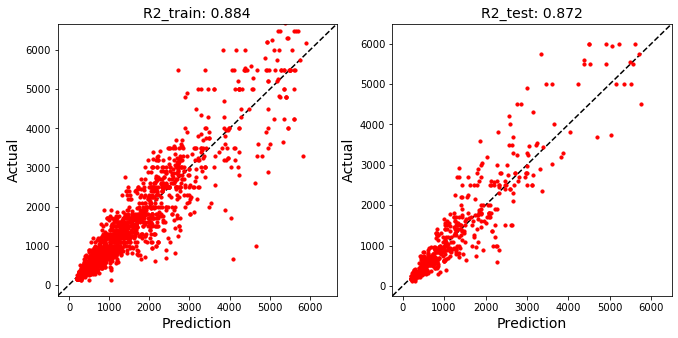

In [30]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

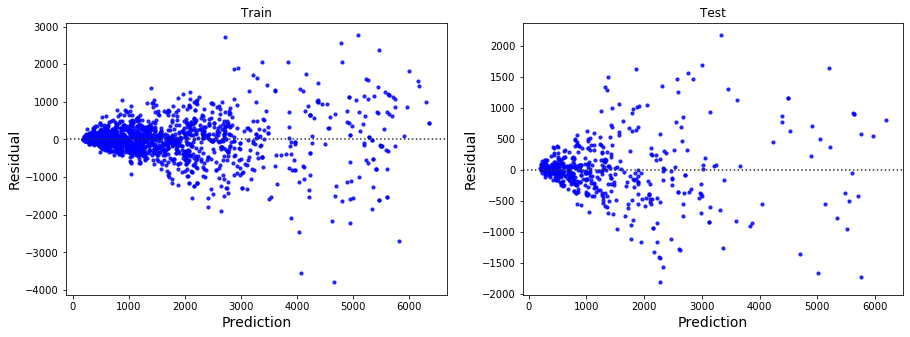

In [31]:
plot_residual(X_train, y_train, X_test, y_test, model)

## Feature Importance

,feature,importance,stdev
2,lsize,0.673869,0.014124
1,hsize,0.279900,0.004944
0,bedroom,0.041986,0.002725
3,location_bin,0.022117,0.001818


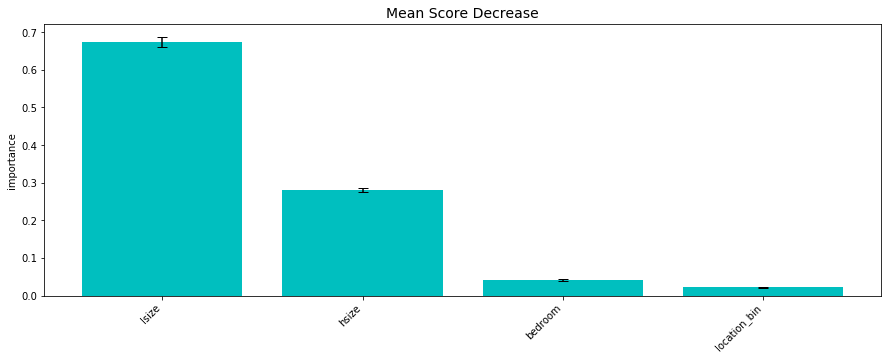

In [32]:
mean_score_decrease(X_train, y_train, model, plot=True)

# AutoML

In [24]:
from jcopml.automl import AutoRegressor

In [25]:
automl = AutoRegressor(['bedroom', 'hsize', 'lsize'], ['location_bin'], random_state=42)

In [27]:
automl.fit(X, y, test_size=0.2)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   26.3s finished


================== Best Model Info ==================
algo                      | KNeighborsRegressor
algo__n_neighbors         | 27
algo__p                   | 1.2952905884189387
algo__weights             | distance

================================ Best Preprocessor Info =================================
categorical_imputer       | SimpleImputer(add_indicator=True, strategy='most_frequent')
categorical_encoder       | OneHotEncoder
num_imputer               | SimpleImputer(add_indicator=True, strategy='median')

=========== Score ===========
Train: 0.9960619230014793
Valid: 0.8236764965930213
Test : 0.8915949567546618


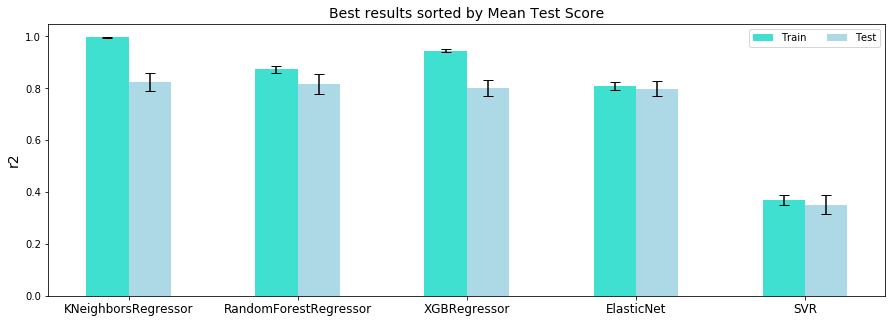

In [28]:
automl.plot_results()

# Conclusion

- KNeighbors have have the highest test result according to AutoML, but the model is overfitted.
- Random Forest and ElasticNet did a great job predicting without overfitting to the training data.
- Residual plot have pattern in price more than Rp. 1,000,000,000 --- indicating that we need more data and more features to predict more accurately.
- Higher lot size is highly correlated with higher price.